In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image
import shutil
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model


2025-10-10 12:11:21.720537: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 12:11:22.254333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 12:11:24.668221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# -------------------------------
# ⚙️ Paramètres
# -------------------------------
dataset_path = "dataset"
img_height, img_width = 224, 224
batch_size = 64


In [ ]:
# -------------------------------
# 🧹 Nettoyage du dataset
# -------------------------------
source_path = "dataset"  # Source original
cleaned_path = "dataset_cleaned"  # Destination nettoyée

# Utiliser la valeur complète de valid_exts
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')
min_size = 50  # taille minimale (pixels)

# Créer le dossier de destination s'il n'existe pas
os.makedirs(cleaned_path, exist_ok=True)

def is_valid_image(file_path):
    """Vérifie si un fichier est une image valide et de taille suffisante."""
    try:
        if not file_path.lower().endswith(valid_exts):
            return False
        with Image.open(file_path) as img:
            w, h = img.size
            if w < min_size or h < min_size:
                return False
            return True
    except (IOError, OSError) as e:
        print(f"Erreur lors de la lecture de {file_path}: {e}")
        return False
    except Exception as e:
        print(f"Erreur inattendue avec {file_path}: {e}")
        return False

# Vérifier si le nettoyage a déjà été effectué
existing_files = sum([len(files) for _, _, files in os.walk(cleaned_path)])
if existing_files > 0:
    print(f"⚠️ Le dossier '{cleaned_path}' contient déjà {existing_files} fichiers.")
    proceed = input("Voulez-vous continuer et écraser les fichiers existants? (o/n): ").lower()
    if proceed != 'o':
        print("Nettoyage annulé.")
        # Ne pas définir dataset_path car cell suivante le fait
        raise SystemExit

removed_files = []
copied_files = 0

for root, dirs, files in os.walk(source_path):
    # Reproduire la structure de dossiers
    rel_path = os.path.relpath(root, source_path)
    dest_dir = os.path.join(cleaned_path, rel_path)
    os.makedirs(dest_dir, exist_ok=True)
    
    for f in files:
        src_path = os.path.join(root, f)
        dest_path = os.path.join(dest_dir, f)
        
        if is_valid_image(src_path):
            shutil.copy2(src_path, dest_path)
            copied_files += 1
        else:
            removed_files.append(src_path)

print(f"✅ {copied_files} images valides copiées dans '{cleaned_path}'")
print(f"🗑️ {len(removed_files)} fichiers exclus (non-images ou trop petits)")
if len(removed_files) > 0:
    print('Exemples exclus :', removed_files[:10])

In [3]:
dataset_path = "dataset_cleaned"


In [4]:
# -------------------------------
# 🗂️ Lecture du dataset
# -------------------------------
from collections import Counter


def count_images(dataset_path):
    valid_exts = (".jpg", ".jpeg", ".png")
    image_paths, labels = [], []
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                if img.lower().endswith(valid_exts):
                    image_paths.append(os.path.join(class_dir, img))
                    labels.append(class_name)

    labels = np.array(labels)
    # comptes par classe
    counts = Counter(labels)
    per_class = {cls: counts[cls] for cls in sorted(counts)}

    return labels,  per_class, image_paths

labels, per_class, image_paths = count_images(dataset_path)
print("Total images :", len(labels))
print("Images par classe :", per_class)


Total images : 40046
Images par classe : {np.str_('Dataset Livrable 1 - Painting'): 10000, np.str_('Dataset Livrable 1 - Photo'): 9991, np.str_('Dataset Livrable 1 - Schematics'): 8649, np.str_('Dataset Livrable 1 - Sketch'): 1406, np.str_('Dataset Livrable 1 - Text'): 10000}


In [5]:
# -------------------------------
# ✂️ Split AVANT oversampling/augmentation
# -------------------------------
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


In [6]:
# -------------------------------
# 🧪 Data generators & augmentation pour MINORITY seulement (train)
# -------------------------------

# Identifie la classe minoritaire dans train_labels
unique, counts = np.unique(train_labels, return_counts=True)
class_counts = dict(zip(unique, counts))
minority_label = unique[np.argmin(counts)]
print("Class counts (train) before augmentation:", class_counts)
print("Minority label:", minority_label)

# Dossier pour stocker images augmentées (séparé)
augmented_dir = "/root/projet_v2/photo_augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Data augmentation à utiliser pour générer fichiers (pas pour val)
save_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Nombre d'images à générer par image minoritaire (ajuster)
n_aug = 5

# Compter déjà présents dans augmented_dir pour éviter doublons si relance
existing_aug = set([f for f in os.listdir(augmented_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])

# Générer augmentations uniquement à partir des images minoritaires présentes dans train_paths
train_paths = list(train_paths)
train_labels = list(train_labels)

for path, label in zip(list(train_paths), list(train_labels)):
    if label != minority_label:
        continue
    try:
        img = load_img(path)
        x = img_to_array(img).reshape((1,) + img_to_array(img).shape)
        i = 0
        for _ in save_datagen.flow(x, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= n_aug:
                break
    except Exception as e:
        print(f"Warning: cannot augment {path}: {e}")

# Récupérer fichiers nouvellement créés et les ajouter au train
new_aug_files = [f for f in os.listdir(augmented_dir) if f.lower().endswith(('.jpg','.jpeg','.png')) and f not in existing_aug]
for fname in new_aug_files:
    train_paths.append(os.path.join(augmented_dir, fname))
    train_labels.append(minority_label)

# Afficher compte après augmentation
unique_after, counts_after = np.unique(train_labels, return_counts=True)
print("Class counts (train) after augmentation:", dict(zip(unique_after, counts_after)), 
      f"(added {len(new_aug_files)} files)")



Class counts (train) before augmentation: {np.str_('Dataset Livrable 1 - Painting'): np.int64(8000), np.str_('Dataset Livrable 1 - Photo'): np.int64(7992), np.str_('Dataset Livrable 1 - Schematics'): np.int64(6919), np.str_('Dataset Livrable 1 - Sketch'): np.int64(1125), np.str_('Dataset Livrable 1 - Text'): np.int64(8000)}
Minority label: Dataset Livrable 1 - Sketch
Class counts (train) after augmentation: {np.str_('Dataset Livrable 1 - Painting'): np.int64(8000), np.str_('Dataset Livrable 1 - Photo'): np.int64(7992), np.str_('Dataset Livrable 1 - Schematics'): np.int64(6919), np.str_('Dataset Livrable 1 - Sketch'): np.int64(3494), np.str_('Dataset Livrable 1 - Text'): np.int64(8000)} (added 2369 files)


In [7]:
# Création des DataFrames et generators (train augmenté, val inchangé)
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 34405 validated image filenames belonging to 5 classes.
Found 8010 validated image filenames belonging to 5 classes.


In [8]:
# -------------------------------
# ⚖️ Class weights (mappés aux indices du generator)
# -------------------------------
labels_sorted = np.unique(train_labels)  # sorted label names used for compute_class_weight
sklearn_weights = compute_class_weight(class_weight='balanced', classes=labels_sorted, y=train_labels)
# mapping label -> weight
weight_label_map = dict(zip(labels_sorted, sklearn_weights))
# mapping index -> weight attendu par model.fit
class_weights = {train_generator.class_indices[label]: weight_label_map[label] for label in labels_sorted}
print("Class weights (index -> weight):", class_weights)


Class weights (index -> weight): {0: np.float64(0.860125), 1: np.float64(0.860985985985986), 2: np.float64(0.994507876860818), 3: np.float64(1.9693760732684602), 4: np.float64(0.860125)}


In [ ]:
from tensorflow.keras import regularizers

inp = Input(shape=(img_height, img_width, 3))

# Bloc Convolutif 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)  # Dropout après le pooling

# Bloc Convolutif 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Bloc Convolutif 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Tête de Classification
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x) 
out = layers.Dense(5, activation='softmax')(x)  # 5 classes

model1 = models.Model(inputs=inp, outputs=out)

model1.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


I0000 00:00:1760098959.925987   91174 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,477 (505.77 KB)

 Trainable params: 128,517 (502.02 KB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
# -------------------------------
# 🚀 Entraînement model 1
# -------------------------------

# Callback pour sauvegarder les meilleurs poids
checkpoint = ModelCheckpoint(
    filepath="best_model1_v4_weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
)

# ✅ Callback pour éviter le sur-apprentissage (patience plus stricte)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,  # plus strict
    restore_best_weights=True,
)

# ✅ Entraînement du modèle
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping],
)

/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7


2025-10-10 12:22:44.172935: I external/local_xla/xla/service/service.cc:163] XLA service 0x70e44c005ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-10 12:22:44.173001: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-10-10 12:22:44.269536: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-10 12:22:44.799272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-10 12:22:45.128723: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-10 12:22:

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6116 - loss: 1.1286

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 422s 375ms/step - accuracy: 0.6878 - loss: 0.8380 - val_accuracy: 0.6840 - val_loss: 0.8467
Epoch 2/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7846 - loss: 0.5174

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 401s 372ms/step - accuracy: 0.7991 - loss: 0.4932 - val_accuracy: 0.7492 - val_loss: 0.7051
Epoch 3/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8232 - loss: 0.4404

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 378s 351ms/step - accuracy: 0.8248 - loss: 0.4352 - val_accuracy: 0.8102 - val_loss: 0.5110
Epoch 4/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 373s 346ms/step - accuracy: 0.8412 - loss: 0.4001 - val_accuracy: 0.6853 - val_loss: 1.0903
Epoch 5/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8553 - loss: 0.3697

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 396s 368ms/step - accuracy: 0.8544 - loss: 0.3765 - val_accuracy: 0.8478 - val_loss: 0.4916
Epoch 6/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 387s 359ms/step - accuracy: 0.8678 - loss: 0.3536 - val_accuracy: 0.8252 - val_loss: 0.5967
Epoch 7/7
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 379s 352ms/step - accuracy: 0.8746 - loss: 0.3419 - val_accuracy: 0.7597 - val_loss: 0.7082


/tmp/ipykernel_91174/2316484540.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_91174/2316484540.py:30: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


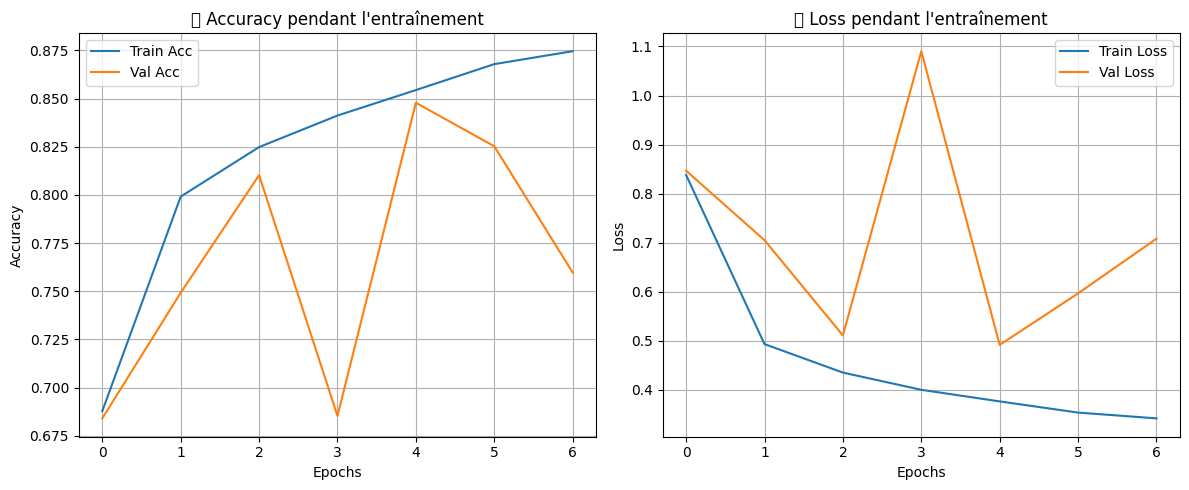

📋 Classification Report :
                                 precision    recall  f1-score   support

  Dataset Livrable 1 - Painting       0.74      0.88      0.80      2000
     Dataset Livrable 1 - Photo       0.88      0.68      0.77      1999
Dataset Livrable 1 - Schematics       0.82      0.92      0.87      1730
    Dataset Livrable 1 - Sketch       0.84      0.93      0.88       281
      Dataset Livrable 1 - Text       0.99      0.91      0.95      2000

                       accuracy                           0.85      8010
                      macro avg       0.85      0.86      0.85      8010
                   weighted avg       0.86      0.85      0.85      8010



/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


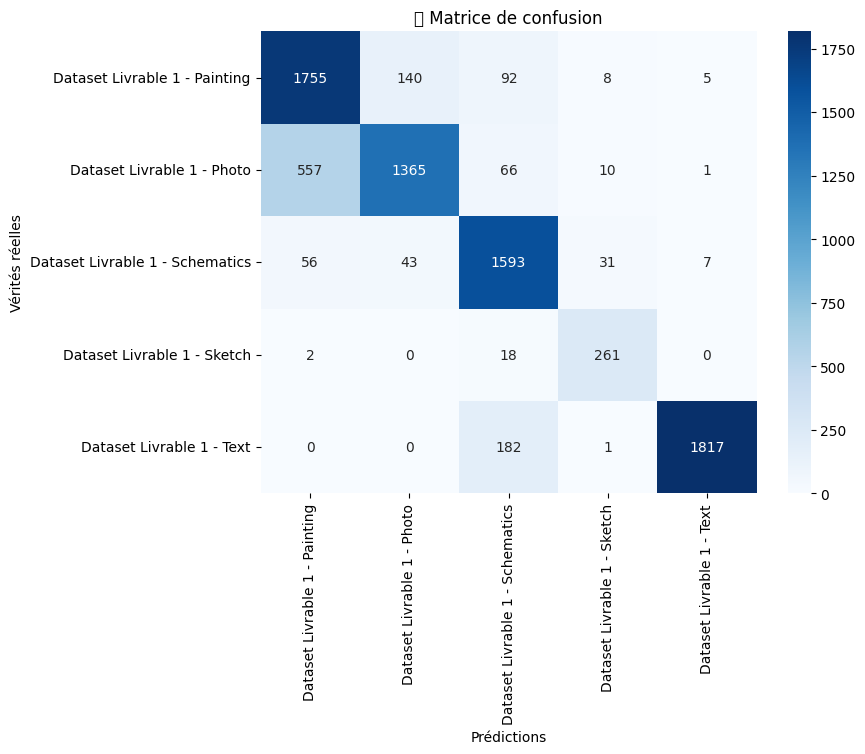

⭐ F1-score (macro, validation) : 0.8538


In [11]:
# Visualisation complète des performances du modèle
# filepath: /root/projet_v2/livrable1_corrected.ipynb

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

# 1. Courbes d'apprentissage (accuracy et loss)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("📈 Accuracy pendant l'entraînement")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("📉 Loss pendant l'entraînement")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Prédictions sur le jeu de validation
val_generator.reset()
y_pred = model1.predict(val_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 3. Rapport de classification (précision, rappel, F1)
print("📋 Classification Report :")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 4. Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧩 Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités réelles")
plt.show()

# 5. F1-score macro sur la validation
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
print(f"⭐ F1-score (macro, validation) : {f1_macro:.4f}")

In [12]:
# filepath: /root/projet_v2/livrable1_corrected.ipynb
val_loss, val_acc = model1.evaluate(val_generator, verbose=1)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.8478 - loss: 0.4916
Validation loss: 0.4916
Validation accuracy: 0.8478


In [13]:
# filepath: /root/projet_v2/livrable1_corrected.ipynb
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = "/root/projet_v2/photo professionnelle.png"
img = load_img(img_path, target_size=(img_height, img_width))
x = img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)
pred = model1.predict(x)
predicted_class = class_labels[np.argmax(pred)]
print("Classe prédite :", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe prédite : Dataset Livrable 1 - Photo


In [14]:
# Transformation des labels multiclasses en labels binaires (photo / nonphoto)
photo_classes = ['Dataset Livrable 1 - Photo']
train_binary_labels = np.where(np.isin(train_labels, photo_classes), 'photo', 'nonphoto')
val_binary_labels = np.where(np.isin(val_labels, photo_classes), 'photo', 'nonphoto')

# Création des DataFrames binaires
train_binary_df = pd.DataFrame({'filename': train_paths, 'class': train_binary_labels})
val_binary_df = pd.DataFrame({'filename': val_paths, 'class': val_binary_labels})

In [15]:
# Affiche le nombre d'images pour chaque classe binaire (photo / nonphoto)
photo_count = np.sum(train_binary_labels == 'photo')
nonphoto_count = np.sum(train_binary_labels == 'nonphoto')
print(f"Nombre d'images 'photo' : {photo_count}")
print(f"Nombre d'images 'nonphoto' : {nonphoto_count}")

Nombre d'images 'photo' : 7992
Nombre d'images 'nonphoto' : 26413


In [16]:

# Générateurs pour la classification binaire
train_binary_generator = train_datagen.flow_from_dataframe(
    dataframe=train_binary_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Mode binaire
    shuffle=True,
    seed=42
)

val_binary_generator = val_datagen.flow_from_dataframe(
    dataframe=val_binary_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Mode binaire
    shuffle=False
)

# Modèle pour classification binaire
inp_binary = Input(shape=(img_height, img_width, 3))

# Architecture simplifiée pour classification binaire
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp_binary)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Tête de classification binaire
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
out_binary = layers.Dense(1, activation='sigmoid')(x)  # Sortie binaire avec sigmoid

model_binary = models.Model(inputs=inp_binary, outputs=out_binary)

model_binary.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',  # Perte binaire
    metrics=['accuracy']
)

print("📊 Modèle binaire :")
model_binary.summary()

Found 34405 validated image filenames belonging to 2 classes.
Found 8010 validated image filenames belonging to 2 classes.
📊 Modèle binaire :


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,297 (434.75 KB)

 Trainable params: 110,593 (432.00 KB)

 Non-trainable params: 704 (2.75 KB)

In [20]:
# Entraînement du modèle binaire
checkpoint_binary = ModelCheckpoint(
    filepath="best_binary_model_weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping_binary = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

print("🚀 Entraînement du modèle binaire...")
history_binary = model_binary.fit(
    train_binary_generator,
    validation_data=val_binary_generator,
    epochs=10,
    callbacks=[checkpoint_binary, early_stopping_binary],
    verbose=1
)


🚀 Entraînement du modèle binaire...
Epoch 1/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8520 - loss: 0.3320
Epoch 1: val_accuracy improved from None to 0.86966, saving model to best_binary_model_weights.h5


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 426s 395ms/step - accuracy: 0.8566 - loss: 0.3218 - val_accuracy: 0.8697 - val_loss: 0.3102
Epoch 2/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8675 - loss: 0.2938
Epoch 2: val_accuracy improved from 0.86966 to 0.87428, saving model to best_binary_model_weights.h5


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 401s 373ms/step - accuracy: 0.8703 - loss: 0.2919 - val_accuracy: 0.8743 - val_loss: 0.2994
Epoch 3/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8807 - loss: 0.2736
Epoch 3: val_accuracy improved from 0.87428 to 0.89263, saving model to best_binary_model_weights.h5


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 398s 369ms/step - accuracy: 0.8819 - loss: 0.2738 - val_accuracy: 0.8926 - val_loss: 0.2605
Epoch 4/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8906 - loss: 0.2581
Epoch 4: val_accuracy did not improve from 0.89263
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 404s 375ms/step - accuracy: 0.8904 - loss: 0.2595 - val_accuracy: 0.8854 - val_loss: 0.3054
Epoch 5/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8939 - loss: 0.2519
Epoch 5: val_accuracy did not improve from 0.89263
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 405s 376ms/step - accuracy: 0.8978 - loss: 0.2449 - val_accuracy: 0.8568 - val_loss: 0.3457
Epoch 6/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9031 - loss: 0.2367
Epoch 6: val_accuracy improved from 0.89263 to 0.91061, saving model to best_binary_model_weights.h5


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 397s 369ms/step - accuracy: 0.9057 - loss: 0.2320 - val_accuracy: 0.9106 - val_loss: 0.2257
Epoch 7/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9150 - loss: 0.2133
Epoch 7: val_accuracy improved from 0.91061 to 0.91698, saving model to best_binary_model_weights.h5


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 401s 371ms/step - accuracy: 0.9144 - loss: 0.2142 - val_accuracy: 0.9170 - val_loss: 0.2042
Epoch 8/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9197 - loss: 0.2079
Epoch 8: val_accuracy did not improve from 0.91698
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 402s 373ms/step - accuracy: 0.9207 - loss: 0.2035 - val_accuracy: 0.8855 - val_loss: 0.2869
Epoch 9/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9228 - loss: 0.1979
Epoch 9: val_accuracy did not improve from 0.91698
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 390s 362ms/step - accuracy: 0.9230 - loss: 0.1937 - val_accuracy: 0.8755 - val_loss: 0.3236
Epoch 10/10
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9278 - loss: 0.1822
Epoch 10: val_accuracy did not improve from 0.91698
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 387s 359ms/step - accuracy: 0.9298 - loss: 0.1800 - val_accuracy: 0.9056 - val_loss: 0.2611


/tmp/ipykernel_91174/3686146020.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_91174/3686146020.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


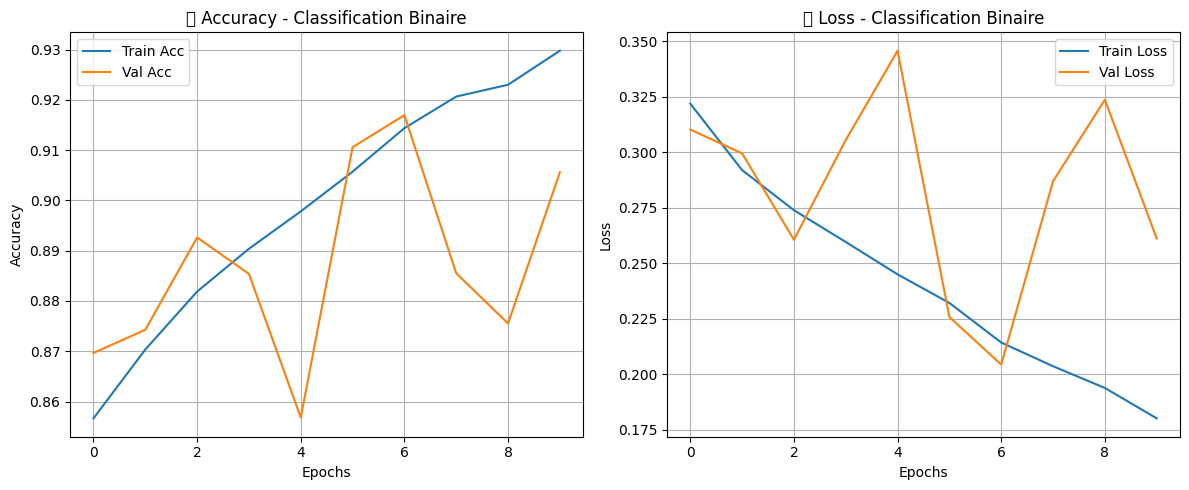

📋 Classification Report - Binaire :
              precision    recall  f1-score   support

    nonphoto       0.95      0.94      0.94      6011
       photo       0.83      0.84      0.83      1999

    accuracy                           0.92      8010
   macro avg       0.89      0.89      0.89      8010
weighted avg       0.92      0.92      0.92      8010



/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


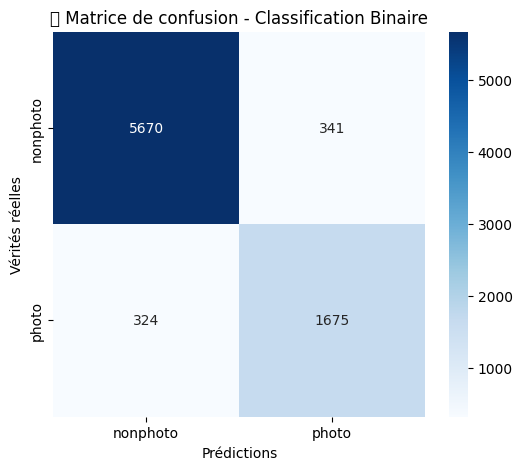

In [22]:
# Visualisation des performances du modèle binaire
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_binary.history['accuracy'], label='Train Acc')
plt.plot(history_binary.history['val_accuracy'], label='Val Acc')
plt.title("📈 Accuracy - Classification Binaire")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_binary.history['loss'], label='Train Loss')
plt.plot(history_binary.history['val_loss'], label='Val Loss')
plt.title("📉 Loss - Classification Binaire")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Évaluation du modèle binaire
val_binary_generator.reset()
y_pred_binary = model_binary.predict(val_binary_generator, verbose=0)
y_pred_binary_classes = (y_pred_binary > 0.5).astype(int).flatten()
y_true_binary = val_binary_generator.classes

print("📋 Classification Report - Binaire :")
print(classification_report(y_true_binary, y_pred_binary_classes, 
                          target_names=['nonphoto', 'photo']))

# Matrice de confusion pour classification binaire
cm_binary = confusion_matrix(y_true_binary, y_pred_binary_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['nonphoto', 'photo'], 
            yticklabels=['nonphoto', 'photo'])
plt.title("🧩 Matrice de confusion - Classification Binaire")
plt.xlabel("Prédictions")
plt.ylabel("Vérités réelles")
plt.show()

# Test sur une image individuelle
def predict_photo_or_not(image_path, model):
    """Prédit si une image est une photo ou non"""
    img = load_img(image_path, target_size=(img_height, img_width))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    confidence = pred[0][0]
    
    if confidence > 0.5:
        return "photo", confidence
    else:
        return "nonphoto", 1 - confidence

# Test du modèle binaire


In [19]:
img_path = "/root/projet_v2/photo professionnelle.png"
result, confidence = predict_photo_or_not(img_path, model_binary)
print(f"🔍 Prédiction binaire: {result} (confiance: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
🔍 Prédiction binaire: nonphoto (confiance: 0.7900)
